# Multilayer perceptron from scratch

### Problem formulation

Let $\mathbf{x} \in \mathbb{R}^2$ denote the input vector and $y \in \{0,1\}$ the corresponding label.

We assume that there exist a function $f(\cdot; \boldsymbol\theta): \mathbb{R}^2 \mapsto [0,1]$ parametrized by $\boldsymbol\theta$ such that:

$$p(y=1|\mathbf{x} ; \theta) = f(\mathbf{x}; \boldsymbol\theta) = \hat{y}, \qquad p(y=0|\mathbf{x} ; \theta) = 1- f(\mathbf{x}; \boldsymbol\theta) = 1- \hat{y}$$

Let's first load the data.

In [1]:
my_seed = 1
import numpy as np
np.random.seed(my_seed)
import torch
torch.manual_seed(my_seed)
import torch.nn as nn
import matplotlib.pyplot as plt
from utils import plot_data, plot_decision_boundary
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
X, Y = make_moons(n_samples=2000, noise=0.1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, random_state=my_seed)

X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
Y_val_tensor = torch.from_numpy(Y_val).float()

print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(X_val_tensor.shape)
print(Y_val_tensor.shape)

torch.Size([1600, 2])
torch.Size([1600])
torch.Size([400, 2])
torch.Size([400])


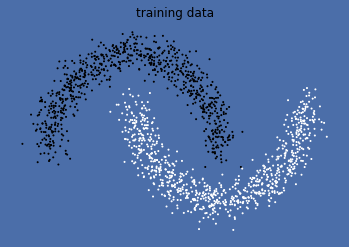

In [3]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_title('training data')
plot_data(ax, X_train, Y_train)

As you have seen, building and training an MLP with PyTorch is a piece of cake, especially because it takes care of backpropagation for us. But to truly understand what's going on, it is useful to an MLP from scratch.

We provide below a class called ```MySecondMLP``` which contains four methods with quite explicit names: the ```forward```, ```backward``` and ```train``` methods.

The **forward pass** consists in computing the output of the model $\hat{y}$ as follows:

$$
\begin{aligned}
\mathbf{u}_1 &= \mathbf{W}_1^\top \mathbf{x} + \mathbf{b}_1, &\qquad \mathbf{W}_1 \in \mathbb{R}^{2 \times H},  \mathbf{b}_1 \in \mathbb{R}^{H \times 1}, \mathbf{x} \in \mathbb{R}^{2 \times 1},\\
\mathbf{u}_2 &= \tanh(\mathbf{u}_1), &\qquad \tanh(\cdot) \text{ is the element-wise hyperbolic tangent},\\
u_3 &= \mathbf{w}_2^\top \mathbf{u}_2 + \mathbf{b}_2, &\qquad \mathbf{w}_1 \in \mathbb{R}^{H \times 1},  \mathbf{b}_2 \in \mathbb{R}\\
\hat{y} &= \sigma(u_3), &\qquad \sigma(\cdot) \text{ is the sigmoid function}. \\
\end{aligned}
$$

**Backward pass**

We recall that

$$
\begin{aligned}
\ell(y, \hat{y}) &= - (y \ln(\hat{y}) + (1-y)\ln(1-\hat{y})), &\qquad \text{ is the cross-entropy loss}\\
\mathcal{L}(\theta) &= \frac{1}{N} \sum_{i=1}^N \ell(y_i, \hat{y}_i), &\qquad \theta = \{\mathbf{W}_1, \mathbf{b}_1, \mathbf{w}_2, b_2\}.
\end{aligned}
$$


We need to compute $\displaystyle \frac{\partial \mathcal{L}}{\partial \eta}$ for all $\eta \in \theta$. We have:

$$ \frac{\partial \mathcal{L}}{\partial \eta} = \frac{1}{N} \sum_{i=1}^N \frac{\partial \ell}{\partial \eta} (y_i, \hat{y}_i), $$
so what we need to do first is to compute the partial derivative $\displaystyle \frac{\partial \ell}{\partial \eta}$ for all $\eta \in \theta$. Then we will simply have to average these partial derivatives over the training dataset.

More precisely, we need to compute:

$$ 
\begin{aligned}
\frac{\partial \ell}{\partial \mathbf{w}_2} &= \frac{\partial \ell}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial u_3} \frac{\partial u_3}{\partial \mathbf{w}_2} \\
\frac{\partial \ell}{\partial b_2} &= \frac{\partial \ell}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial u_3} \frac{\partial u_3}{\partial b_2} \\
\frac{\partial \ell}{\partial \mathbf{W}_1} &= \frac{\partial \ell}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial u_3} \frac{\partial u_3}{\partial \mathbf{u}_2} \frac{\partial \mathbf{u}_2}{\partial \mathbf{u}_1} \frac{\partial \mathbf{u}_1}{\partial \mathbf{W}_1} \\
\frac{\partial \ell}{\partial \mathbf{b}_1} &= \frac{\partial \ell}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial u_3} \frac{\partial u_3}{\partial \mathbf{u}_2} \frac{\partial \mathbf{u}_2}{\partial \mathbf{u}_1} \frac{\partial \mathbf{u}_1}{\partial \mathbf{b}_1}.
\end{aligned}
$$

Let us introduce the following quantities:

$$
\begin{aligned}
\delta_3 &= \frac{\partial \ell}{\partial u_3} = \frac{\partial \ell}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial u_3}  \\
\boldsymbol\delta_1 &= \frac{\partial \ell}{\partial \mathbf{u}_1}= \frac{\partial \ell}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial u_3} \frac{\partial u_3}{\partial \mathbf{u}_2} \frac{\partial \mathbf{u}_2}{\partial \mathbf{u}_1} = \delta_3 \frac{\partial u_3}{\partial \mathbf{u}_2} \frac{\partial \mathbf{u}_2}{\partial \mathbf{u}_1} .
\end{aligned}
$$

The partial derivatives can be rewritten as:

$$ 
\begin{aligned}
\frac{\partial \ell}{\partial \mathbf{w}_2} &= \delta_3 \frac{\partial u_3}{\partial \mathbf{w}_2} \\
\frac{\partial \ell}{\partial b_2} &= \delta_3 \frac{\partial u_3}{\partial b_2} \\
\frac{\partial \ell}{\partial \mathbf{W}_1} &= \boldsymbol\delta_1\frac{\partial \mathbf{u}_1}{\partial \mathbf{W}_1} \\
\frac{\partial \ell}{\partial \mathbf{b}_1} &= \boldsymbol\delta_1 \frac{\partial \mathbf{u}_1}{\partial \mathbf{b}_1}.
\end{aligned}
$$

Because matrix derivatives can be quite tricky, we provide you with the results of the above partial derivations. We refer the reader interested into the derivation details to the following ressources:
- https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf
- https://explained.ai/matrix-calculus/
- http://media.ee.ntu.edu.tw/personal/pcwu/tutorials/matrix_calculus.pdf



After some calculus, we have:

$$ 
\begin{aligned}
\delta_3 &= \hat{y} - y \in \mathbb{R} \\
\frac{\partial \ell}{\partial \mathbf{w}_2} &= \delta_3 \mathbf{u}_2 \in \mathbb{R}^{H \times 1} \\
\frac{\partial \ell}{\partial b_2} &= \delta_3 \in \mathbb{R} \\
\boldsymbol\delta_1 &= \delta_3 \mathbf{w}_2 \odot \left(1 - \mathbf{u}_2^{\odot 2} \right) \in \mathbb{R}^{H \times 1} \\
\frac{\partial \ell}{\partial \mathbf{W}_1} &=  \mathbf{x} \boldsymbol\delta_1^\top \in \mathbb{R}^{2 \times H}, \\
\frac{\partial \ell}{\partial \mathbf{b}_1} &=  \boldsymbol\delta_1 \in \mathbb{R}^{H \times 1}, 
\end{aligned}
$$
where $\odot$ denotes element-wise operations.

The forward and backward pass are implemented below, along with the training loop that calls the forward and backward methods.

In [8]:
class MySecondMLP:
    
    def __init__(self, input_dim=2, output_dim=1, hidden_dim=50):
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        # We initialize the network parameters
        # as in https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        RK = torch.tensor([np.sqrt(self.input_dim)], dtype=torch.float)
        self.W1 = -2 * RK * torch.rand(self.input_dim, self.hidden_dim, dtype=torch.float) + RK # shape (input_dim, hidden_dim)
        self.b1 = -2 * RK * torch.rand(self.hidden_dim, 1, dtype=torch.float) + RK # shape (hidden_dim, 1)

        RK = torch.tensor([np.sqrt(self.hidden_dim)], dtype=torch.float)
        self.W2 = -2 * RK * torch.rand(self.hidden_dim, self.output_dim, dtype=torch.float) + RK # shape (hidden_dim, output_dim)
        self.b2 = -2 * RK * torch.rand(self.output_dim, 1, dtype=torch.float) + RK # shape (output_dim, 1)
                        
    def forward(self, X):
        '''
        X: shape (N, 2)
        '''
        
        self.U1 = self.W1.T @ X.T + self.b1 # shape (hidden_dim, N)
        self.U2 = torch.tanh(self.U1) # shape (hidden_dim, N)
        self.U3 = self.W2.T @ self.U2 + self.b2 # shape (output_dim, N)
        self.Y_hat = torch.sigmoid(self.U3) # shape (output_dim, N)
        
        return self.Y_hat
    
    def backward(self, X, Y):
        '''
        X: shape (N, 2)
        Y: shape (N)
        '''        
        
        N = X.shape[0]
        
        self.delta3 = self.Y_hat - Y # shape (1, N)
        self.dW2 = torch.mean(self.delta3 * self.U2, dim=1, keepdim=True) # shape (hidden_dim, 1)
        self.db2 = torch.mean(self.delta3, dim=1, keepdim=True) / N # shape (1, 1)
        self.delta1 = self.delta3 * self.W2 * (1 - self.U2**2) # shape (hidden_dim, N)
        self.dW1 = X.T @ self.delta1.T / N  # shape (input_dim, hidden_dim)
        self.db1 = torch.mean(self.delta1, dim=1, keepdim=True) # shape (hidden_dim, 1)
        
    def train(self, X_train, Y_train, X_val, Y_val, num_epochs, learning_rate):
        
        eps = torch.tensor([1e-10])
        
        training_loss = []
        val_loss = []
                
        for epoch in range(num_epochs):
            
            # do the forward pass
            self.forward(X_train)
            
            # compute and store the loss on the training set
            loss = -torch.mean(
                Y_train * torch.log(self.Y_hat + eps) + 
                (1 - Y_train) * torch.log(1 - self.Y_hat + eps) 
            )
            training_loss.append(loss)
            
            # do the backward
            self.backward(X_train, Y_train)
            
            # do a gradient descent step
            self.W1 -= learning_rate * self.dW1
            self.b1 -= learning_rate * self.db1
            self.W2 -= learning_rate * self.dW2
            self.b2 -= learning_rate * self.db2
            
            # compute and store the loss on the validation set
            self.forward(X_val)
            loss = -torch.mean(
                Y_val * torch.log(self.Y_hat + eps) + 
                (1 - Y_val) * torch.log(1 - self.Y_hat + eps)
            )
            val_loss.append(loss)
    
        return training_loss, val_loss

Let's now train this MLP implemented from scratch!

Text(0.5, 0, 'epochs')

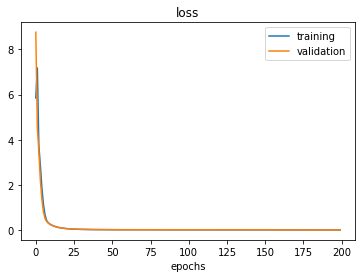

In [9]:
my_nn = MySecondMLP(input_dim=2, output_dim=1, hidden_dim=50)

train_loss, val_loss = my_nn.train(X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, 200, 1)

plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["training", "validation"])
plt.title("loss")
plt.xlabel("epochs")


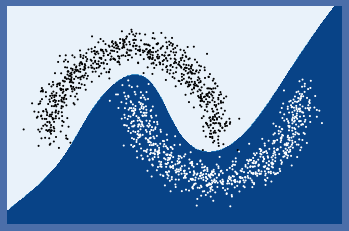

In [10]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
plot_decision_boundary(ax, X_train_tensor, Y_train_tensor, my_nn, use_tensor=True)

## Questions

(use the PyTorch implementation to answer these questions)

- What results do you obtain if you remove the hidden layer? Why?
- What results do you obtain if you add one or several hidden layers?
- What happens if you choose a learning rate that is either too low or too high?
- How can you use the validation set to choose the number of hidden layers and the number of training iterations?